In [2]:
import numpy as np
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import imutils

from keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.utils import shuffle #shuffling the data improves the model


import seaborn as sns
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, RMSprop

In [3]:
image_dir="BrainTumorDetection/DataSet_brain_tumor/brain_tumor_dataset/"

In [4]:
try:
    os.makedirs('BrainTumorDetection/DataSet_brain_tumor/brain_tumor_dataset/augmented-images/')
    os.makedirs('BrainTumorDetection/DataSet_brain_tumor/brain_tumor_dataset/augmented-images/yes/')
    os.makedirs('BrainTumorDetection/DataSet_brain_tumor/brain_tumor_dataset/augmented-images/no/')
except:
    print("Folder already exists.\nSkipping to create.")

In [5]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [6]:
augmented_data_path ='BrainTumorDetection/DataSet_brain_tumor/brain_tumor_dataset/augmented-images/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

In [7]:
#Crop image to eliminate empty black space (https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

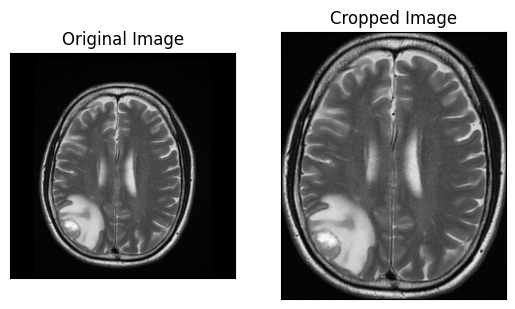

In [8]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [9]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [10]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [11]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

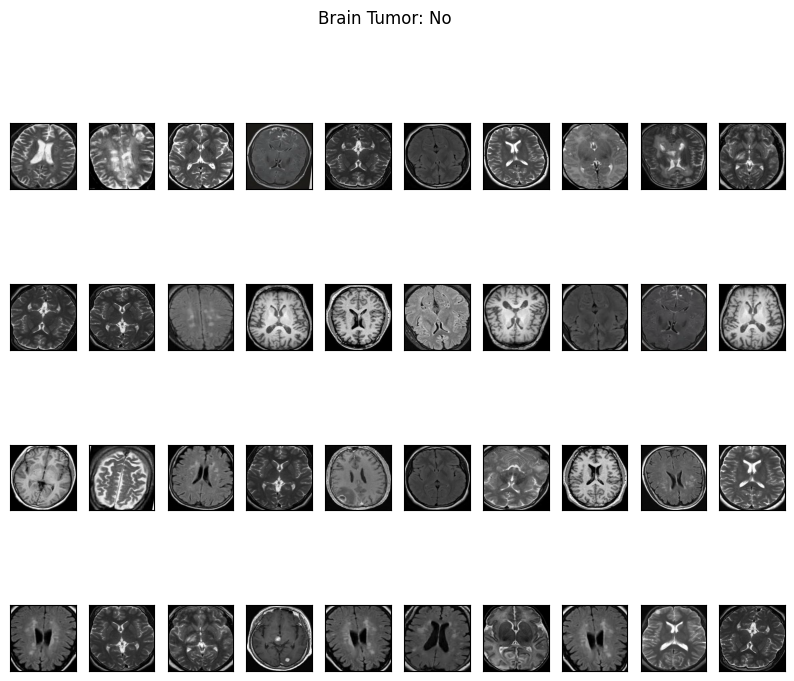

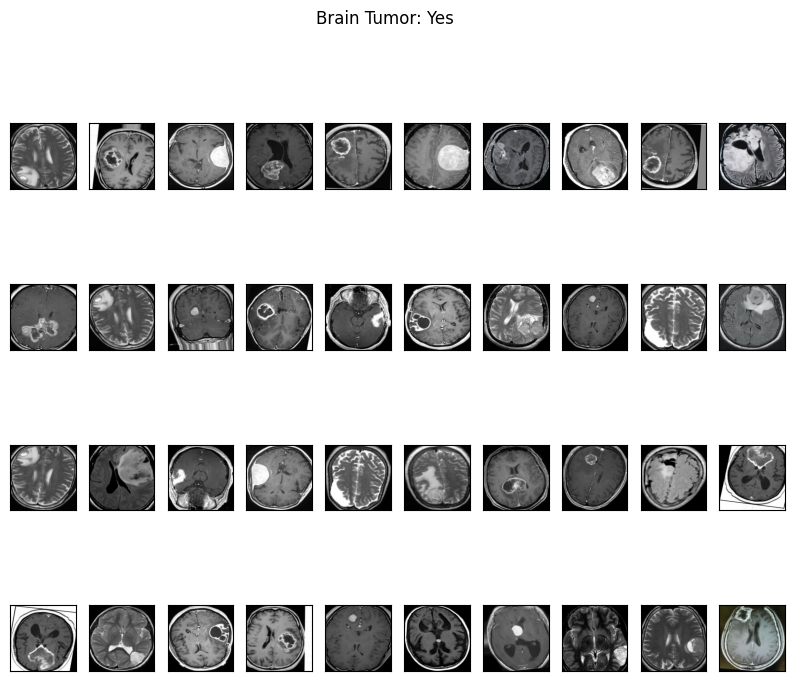

In [12]:
plot_sample_images(X, y)

In [13]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [15]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1445
number of validation examples = 310
number of test examples = 310


In [16]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
    
    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)
    
    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.5)(X)  # Use tf.keras.layers.Dropout instead of Dropout
    
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model

In [18]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 244, 244, 3)       0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation_1 (Activation)   (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 59, 59, 32)        0         
 g2D)                                                      

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))


Epoch 1/50


46/46 [==============================] - 64s 1s/step - loss: 1.2357 - accuracy: 0.6039 - val_loss: 0.6644 - val_accuracy: 0.6484
Epoch 2/50
46/46 [==============================] - 58s 1s/step - loss: 0.6040 - accuracy: 0.6814 - val_loss: 0.6296 - val_accuracy: 0.6871
Epoch 3/50
46/46 [==============================] - 56s 1s/step - loss: 0.5842 - accuracy: 0.6780 - val_loss: 0.6191 - val_accuracy: 0.7613
Epoch 4/50
46/46 [==============================] - 56s 1s/step - loss: 0.5525 - accuracy: 0.7237 - val_loss: 0.5851 - val_accuracy: 0.7226
Epoch 5/50
46/46 [==============================] - 58s 1s/step - loss: 0.4984 - accuracy: 0.7555 - val_loss: 0.5365 - val_accuracy: 0.7516
Epoch 6/50
46/46 [==============================] - 57s 1s/step - loss: 0.4751 - accuracy: 0.7632 - val_loss: 0.4492 - val_accuracy: 0.7935
Epoch 7/50
46/46 [==============================] - 59s 1s/step - loss: 0.4836 - accuracy: 0.7645 - val_loss: 0.5079 - val_accuracy: 0.7516
Epoch 8/50
46/46 

In [20]:
history = model.history.history

In [21]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

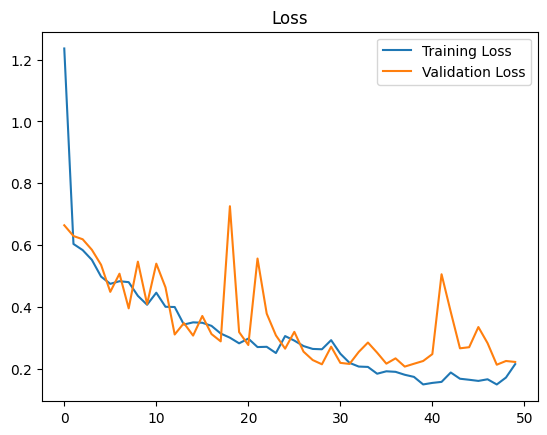

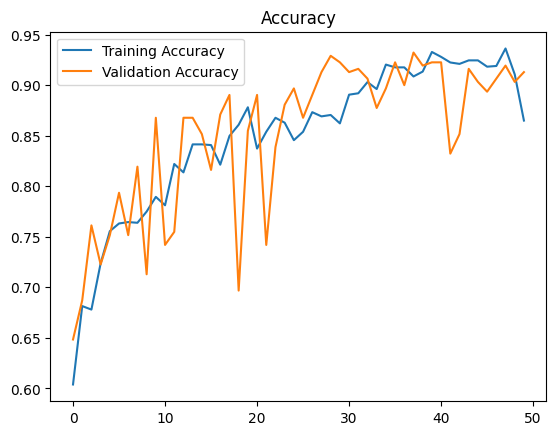

In [22]:
plot_metrics(history)

In [23]:
loss, accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test loss: {loss * 100:.2f}%")

10/10 [==============================] - 3s 250ms/step - loss: 0.2913 - accuracy: 0.9129
Test Accuracy: 91.29%
Test loss: 29.13%


10/10 [==============================] - 3s 234ms/step


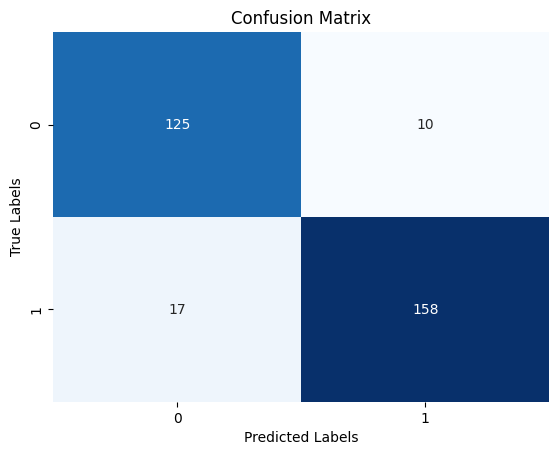

In [24]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [29]:
# Load pre-trained VGG16 model with ImageNet weights
#vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# load base model
vgg16_weight_path = 'model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SHAPE
)

In [30]:
model = Sequential()
model.add(vgg16_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
46/46 [==============================] - 804s 18s/step - loss: 0.5228 - accuracy: 0.7439 - val_loss: 0.2830 - val_accuracy: 0.9290
Epoch 2/22
46/46 [==============================] - 813s 18s/step - loss: 0.2634 - accuracy: 0.9059 - val_loss: 0.2396 - val_accuracy: 0.9097
Epoch 3/22
46/46 [==============================] - 801s 17s/step - loss: 0.1954 - accuracy: 0.9398 - val_loss: 0.1681 - val_accuracy: 0.9581
Epoch 4/22
46/46 [==============================] - 806s 18s/step - loss: 0.1512 - accuracy: 0.9516 - val_loss: 0.1438 - val_accuracy: 0.9645
Epoch 5/22
46/46 [==============================] - 804s 18s/step - loss: 0.1129 - accuracy: 0.9730 - val_loss: 0.1315 - val_accuracy: 0.9581
Epoch 6/22
46/46 [==============================] - 812s 18s/step - loss: 0.0977 - accuracy: 0.9765 - val_loss: 0.1108 - val_accuracy: 0.9710
Epoch 7/22
46/46 [==============================] - 814s 18s/step - loss: 0.0827 - accuracy: 0.9834 - val_loss: 0.1038 - val_accuracy: 0.9710
Epoch 

In [33]:
history = model.history.history

In [34]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

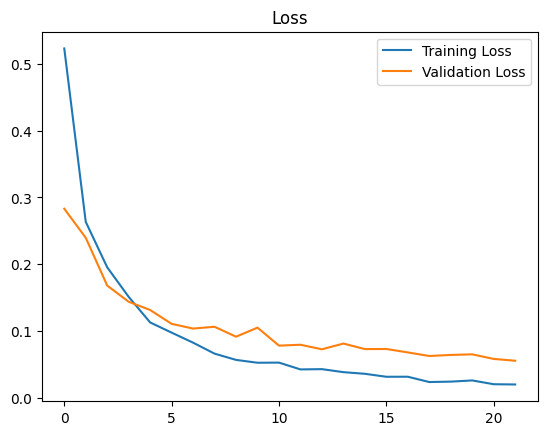

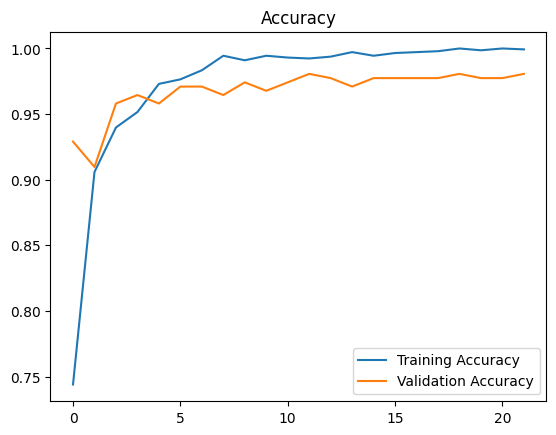

In [35]:
plot_metrics(history)

10/10 [==============================] - 145s 14s/step


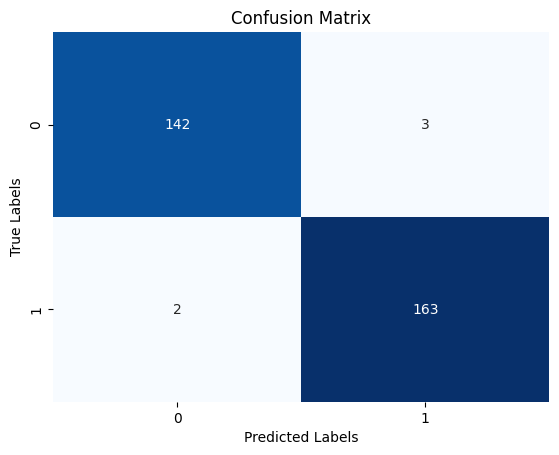

In [36]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [37]:
score = model.evaluate(X_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])
print('\n', 'Test loss:', score[0])


 Test accuracy: 0.9838709831237793

 Test loss: 0.05949145182967186


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

prec_score = precision_score(y_test, y_pred_binary)
print(f'Precision Score: {prec_score}')
rec_score = recall_score(y_test, y_pred_binary)
print(f'Recall Score: {rec_score}')
f1s = f1_score(y_test, y_pred_binary)
print(f'F1 Score: {f1s}')

Precision Score: 0.9819277108433735
Recall Score: 0.9878787878787879
F1 Score: 0.9848942598187311


In [40]:
model.save("saved/my_model.h5")
print("Saved model to disk")

Saved model to disk
